In [1]:
import pandas as pd
import numpy as np

medsCohort = pd.read_stata("/Users/burke/Documents/research/bpCog/meds.dta")
medsCohort['antiHypertensiveCount'] = medsCohort[['medsbpace', 'medsbparb', 'medsbpalphabs', 'medsbpbetabs', 'medsbpcalbs', 'medsbpdiur', 'medsbprenin', 'medsbpvas', 'medsbpoth', 'afibslfrep', 'Hxafib', 'afibinc',]].sum(axis=1)
medsCohort['statin'] = medsCohort.medsstatinshchol
medsCohort['afib'] = medsCohort.index.isin(medsCohort.loc[(medsCohort.afibslfrep==1) |  (medsCohort.Hxafib == 1) | (medsCohort.afibinc == 1)].index)
medsCohort['afib'] = medsCohort['afib'].astype('int')

medsCohort= medsCohort[['newid', 'antiHypertensiveCount', 'statin', 'visitcounter', 'afib']]

completeCohort = pd.read_stata("/Users/burke/Documents/research/bpCog/combinedCohort.dta")

#completeCohort =  pd.read_csv("/Users/burke/Documents/research/bpCog/combinedCohort.csv", low_memory=False)

In [2]:
completeCohort['newid'] = completeCohort['newid'].str[2:-1]

In [3]:
len(completeCohort['newid'].unique())

41163

In [4]:
medsCohort.head()

,newid,antiHypertensiveCount,statin,visitcounter,afib
0,100016012504cardia,0.0,NaN,1,0
1,100016012504cardia,0.0,NaN,2,0
2,100016012504cardia,0.0,NaN,3,0
3,100016012504cardia,0.0,NaN,4,0
4,100023004268cardia,0.0,NaN,1,0


In [5]:
completeCohort.drop(labels=['afibinc', 'hxafib', 'afibslfrep', 'ttoafib', 'afibdt', 'afib'], axis='columns', inplace=True)
completeCohort = completeCohort.merge(medsCohort, how='left', on=['newid', 'visitcounter'])

In [6]:
completeCohort.drop(labels=['sbpavg', 'dbpavg'], axis='columns', inplace=True)
completeCohort['sbpavg'] = completeCohort[['sbp1', 'sbp2', 'sbp3']].mean(axis=1)
completeCohort['dbpavg'] = completeCohort[['dbp1', 'dbp2', 'dbp3']].mean(axis=1)

In [7]:
completeCohort.racebpcog.value_counts()

2    177722
1     61078
3     36458
9      5528
Name: racebpcog, dtype: int64

In [12]:
completeCohort.creatin.isna().value_counts()

True     154206
False    126580
Name: creatin, dtype: int64

In [14]:
cohort = completeCohort[['newid', 'visitcounter', 'sbpavg', 'dbpavg', 'bmi', 'trig', 'smokestatus', 'choltot', 'cholhdl', 'cholldl', 
                 'age0', 'female0', 'educ0', 'daysfromvisit1', 'racebpcog', 'hba1c', 'glucosef', 'educ0', 'physact', 'waistcm',
                 'antiHypertensiveCount', 'statin', 'afib', 'alcperwk', 'creatin']]

# build a clean new index in the cohort using the newid groups
cohort = cohort.assign(id=(cohort['newid']).astype('category').cat.codes)
cohort.drop(labels=['newid'], axis='columns', inplace=True)

cohort.rename(columns={'sbpavg' : 'sbp', 'dbpavg' : 'dbp', 'smokestatus' : 'smokingStatus', 'choltot' : 'totChol',
                      "cholhdl" : 'hdl', 'cholldl' : 'ldl', 'age0' : 'baseAge', 'female0' : 'gender', 'educ0' : 'education',
                      'hba1c' : 'a1c', 'racebpcog' : 'raceEthnicity', 'waistcm' : 'waist', 'physact' : 'anyPhysicalActivity', 
                       'alcperwk' : 'alcoholPerWeek', 'creatin' : 'creatinine'}, inplace=True)


cohort = cohort.loc[:,~cohort.columns.duplicated()]


cohort.gender.replace(to_replace=[0,1], value=[1, 2], inplace=True)
# have to compress "hispanic" to "other hispanic" and no representation for mexican american in BP Cog
cohort.raceEthnicity = cohort.raceEthnicity.replace({1 : 4, 2 : 3,3 : 2,9 : 5}) 

In [15]:
cohort.alcoholPerWeek.describe()

count    179894.000000
mean         30.236853
std          94.567772
min           0.000000
25%           0.000000
50%           0.000000
75%          15.000000
max        5228.189941
Name: alcoholPerWeek, dtype: float64

In [16]:
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi", "dbp", "sbp", "ldl", "trig", "glucosef", "waist", "anyPhysicalActivity", 'afib', 'antiHypertensiveCount', 'statin', 'alcoholPerWeek', 'creatinine']

lagVars = []

# first geneate lag variables which we'll use in teh imputation
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    lagVars.append(newVarName)
    cohort[newVarName] = cohort.groupby(['id'])[factor].shift(1)
    cohort = cohort.join(other=cohort.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    cohort.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)
cohort.drop(lagVars, axis='columns', inplace=True)

cohort['age'] = cohort.baseAge + cohort.daysfromvisit1 / 365
cohort = pd.concat([cohort, pd.get_dummies(cohort['raceEthnicity'], prefix="raceEth")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['smokingStatus'], prefix="smoke")], axis=1)
cohort = pd.concat([cohort, pd.get_dummies(cohort['education'], prefix="educ")], axis=1)


cohort.drop(['baseAge', 'daysfromvisit1', 'visitcounter', 'smokingStatus', 'raceEthnicity', 'education'], axis='columns', inplace=True)

cohort.rename(columns={'raceEth_2' : 'raceEth2', 'raceEth_3' : 'raceEth3', 'raceEth_4' : 'raceEth4',
                        'raceEth_5' : 'raceEth5', 'smoke_0.0' : 'smoke0', 'smoke_1.0' : 'smoke1' , 
                       'smoke_2.0' : 'smoke2', 'educ_1.0' : 'educ1', 'educ_2.0' : 'educ2', 'educ_3.0' : 'educ3',
                      'educ_4.0' : 'educ4', 'educ_5.0' : 'educ5'}, inplace=True)


In [17]:
cohort.alcoholPerWeek.isna().sum()

100892

In [18]:
import statsmodels.imputation.mice as mice

def getFormulaForVariable(var):
    cols = list(cohort.columns)
    cols.remove(var)
    colStrings = [col + "+"for col in cols]
    return "".join(colStrings)[:-1]
    
imputedCohort = mice.MICEData(cohort)
#binaryVars = ['anyPhysicalActivity', 'smoke0', 'smoke1', 'smoke2', 'raceEth2', 'raceEth3', 'raceEth4', 'raceEth5', 'educ1', 'educ2', 'educ3', 'educ4', 'educ5']
#for var in binaryVars: 
#    imputedCohort.set_imputer(var, formula=getFormulaForVariable(var), model_class="logit")
imputedCohort.update_all(20)

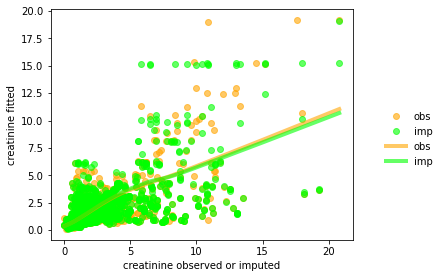

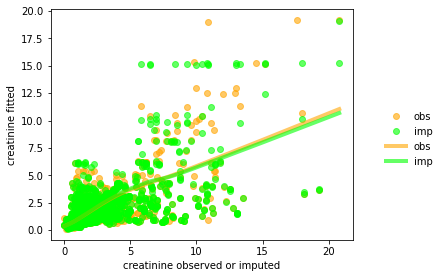

In [19]:
%matplotlib inline
imputedCohort.plot_fit_obs("creatinine")

In [20]:
imputedCohort.data.creatinine.describe()

count    280786.000000
mean          0.973500
std           0.422595
min           0.000000
25%           0.777800
50%           0.919000
75%           1.100000
max          20.799988
Name: creatinine, dtype: float64

In [21]:
imputedData = imputedCohort.data.copy()

# rebvuild categoricals
imputedData['smokingStatus'] = imputedData[['smoke0', 'smoke1', 'smoke2']].idxmax(axis=1)
imputedData['smokingStatus'] = imputedData['smokingStatus'].str[-1:]
imputedData['raceEthnicity'] = imputedData[['raceEth2', 'raceEth3', 'raceEth4', 'raceEth5']].idxmax(axis=1)
imputedData['raceEthnicity'] = imputedData['raceEthnicity'].str[-1:]

In [22]:
# drop the dummies
imputedData.drop(['smoke0', 'smoke1','smoke2'], axis='columns', inplace=True)
imputedData.drop(['raceEth2', 'raceEth3','raceEth3', 'raceEth4', 'raceEth5'], axis='columns', inplace=True)
imputedData.drop(['educ1', 'educ2','educ3', 'educ4', 'educ5'], axis='columns', inplace=True)
imputedData.drop(list(imputedData.filter(regex='mean')), axis='columns', inplace=True)
# drop the mean variables (they were partially imputed)

In [23]:
# rebuild the mean variables off the impuated values
allFactorsImputation = ["a1c", "hdl", "totChol", "bmi","ldl", "trig", "glucosef",  "waist", "anyPhysicalActivity", "antiHypertensiveCount", "statin", "afib", 'alcoholPerWeek', 'creatinine']
logFactorsImputation = ["dbp", "sbp"]

In [24]:
for factor in allFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[newVarName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={newVarName + "mean" : 'mean' + newVarName[0].upper() + newVarName[1:]}, inplace=True)

In [25]:
for factor in logFactorsImputation:
    newVarName = "lag" + factor[0].upper()+factor[1:]
    imputedData[newVarName] = imputedData.groupby(['id'])[factor].shift(1)
    logLagName = "log" + newVarName[0].upper() + newVarName[1:]
    logName = "log" + factor[0].upper() + factor[1:]

    imputedData[logName] = np.log(imputedData[factor])  
    imputedData[logLagName] = np.log(imputedData[newVarName])  
    imputedData = imputedData.join(other=imputedData.groupby(['id'])[logLagName].mean(), on='id', rsuffix='mean')
    imputedData.rename(columns={logLagName + "mean" : 'mean' + logLagName[0].upper() + logLagName[1:]}, inplace=True)

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
imputedData.raceEthnicity= imputedData.raceEthnicity.astype('category')
imputedData.smokingStatus= imputedData.smokingStatus.astype('category')
imputedData.sort_values(by=['id', 'age'], inplace=True)

In [27]:
imputedData.raceEthnicity.value_counts()

3    177722
4     61078
2     36458
5      5528
Name: raceEthnicity, dtype: int64

In [33]:
import statsmodels.formula.api as statsmodel
import sys
import os
sys.path.append(os.path.abspath("../microsim/"))
from microsim.regression_model import RegressionModel

regResults = {}

def buildAndExportRegressionModelForDataset(outcomeVariable , fullDataset, hasLog): 
    factors = allFactors.copy()
    factors.extend(logFactors)
    factors.remove(outcomeVariable)
    factors = ["mean" + factor[0].upper() + factor[1:] + " + " + factor + " + " for factor in factors] 
    
    meanLagOutcomeVariable =  "mean" + outcomeVariable[0].upper() + outcomeVariable[1:]
    
    if (not hasLog):
        outcomeVariable = outcomeVariable[3:4].lower() + outcomeVariable[4:] # remove the lag
    else:
        outcomeVariable = "log" + outcomeVariable[-3:] # remove the lag and add the log
    
    formula = outcomeVariable + " ~ " + "".join(factors) + "age + gender + smokingStatus + raceEthnicity + " + meanLagOutcomeVariable

    print("outcome: " + outcomeVariable + " hasLog: " + str(hasLog) + " : " +formula)

    model = statsmodel.ols(formula=formula, data=fullDataset)
    results = model.fit()
    regResults[outcomeVariable] = results
    mcmRegressionModel = RegressionModel(results.params.to_dict(), results.bse.to_dict(), results.resid.mean(), results.resid.std())
    mcmRegressionModel.write_json(os.path.abspath("../microsim/microsim/data/" + outcomeVariable + "CohortModelSpec.json"))
    #results.save("/Users/burke/Documents/research/bpCog/mcm/mcm/data/" + outcomeVariable +  "CohortModel.pickle")
    return results


allFactors = ["lagA1c", "lagHdl", "lagTotChol", "lagBmi", "lagLdl", "lagTrig", "lagWaist", "lagAnyPhysicalActivity", "lagAntiHypertensiveCount", "lagStatin", "lagAfib", 'lagAlcoholPerWeek', 'lagCreatinine']
logFactors = ["logLagDbp", "logLagSbp"]

imputedData['logDbp'].loc[imputedData['logDbp'] <= 0] = imputedData['logDbp'].loc[imputedData['logDbp']> 0].min()
imputedData['logLagDbp'].loc[imputedData['logLagDbp'] <= 0] = imputedData['logLagDbp'].loc[imputedData['logLagDbp']> 0].min()
imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp'] <= 0] = imputedData['meanLogLagDbp'].loc[imputedData['meanLogLagDbp']> 0].min()



for factor in allFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, False)
for factor in logFactors:
    buildAndExportRegressionModelForDataset(factor, imputedData, True)
    

/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/burke/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

outcome: a1c hasLog: False : a1c ~ meanLagHdl + lagHdl + meanLagTotChol + lagTotChol + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLagWaist + lagWaist + meanLagAnyPhysicalActivity + lagAnyPhysicalActivity + meanLagAntiHypertensiveCount + lagAntiHypertensiveCount + meanLagStatin + lagStatin + meanLagAfib + lagAfib + meanLagAlcoholPerWeek + lagAlcoholPerWeek + meanLagCreatinine + lagCreatinine + meanLogLagDbp + logLagDbp + meanLogLagSbp + logLagSbp + age + gender + smokingStatus + raceEthnicity + meanLagA1c
outcome: hdl hasLog: False : hdl ~ meanLagA1c + lagA1c + meanLagTotChol + lagTotChol + meanLagBmi + lagBmi + meanLagLdl + lagLdl + meanLagTrig + lagTrig + meanLagWaist + lagWaist + meanLagAnyPhysicalActivity + lagAnyPhysicalActivity + meanLagAntiHypertensiveCount + lagAntiHypertensiveCount + meanLagStatin + lagStatin + meanLagAfib + lagAfib + meanLagAlcoholPerWeek + lagAlcoholPerWeek + meanLagCreatinine + lagCreatinine + meanLogLagDbp + logLagDbp + meanLogL

In [34]:
imputedData.anyPhysicalActivity.value_counts(normalize=True)

1.0    0.812288
0.0    0.187712
Name: anyPhysicalActivity, dtype: float64

In [35]:
regResults['logSbp'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logSbp   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                 1.132e+04
Date:                Thu, 29 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:46:15   Log-Likelihood:             2.2909e+05
No. Observations:              239623   AIC:                        -4.581e+05
Df Residuals:                  239586   BIC:                        -4.577e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0873      0.009     10.226      0.000       0.071       0.104
smokingStatus[T.1]               0.0023      0.000      4.640      0.000       0.001       0.003
smokingStatus[T.2]               0.0026      0.001      3.904      0.000       0.001       0.004
raceEthnicity[T.3]              -0.0032      0.001     -4.967      0.000      -0.004      -0.002
raceEthnicity[T.4]              -0.0015      0.001     -2.053      0.040      -0.003   -6.77e-05
raceEthnicity[T.5]               0.0035      0.001      2.369      0.018       0.001       0.006
meanLagA1c                       0.0004      0.000      1.113      0.266      -0.000       0.001
lagA1c                           0.0003      0.000      1.117      0.264      -0.000       0.001
meanLagHdl                       0.0003      0.000      1.275      0.202      -0.000       0.001
lagHdl                           0.0003      0.000      2.221      0.026    3.25e-05       0.001
meanLagTotChol                  -0.0003      0.000     -1.406      0.160      -0.001       0.000
lagTotChol                      -0.0001      0.000     -1.229      0.219      -0.000    8.68e-05
meanLagBmi                      -0.0008      0.000     -4.502      0.000      -0.001      -0.000
lagBmi                          -0.0005      0.000     -3.846      0.000      -0.001      -0.000
meanLagLdl                       0.0003      0.000      1.505      0.132      -0.000       0.001
lagLdl                           0.0002      0.000      1.959      0.050   -1.18e-07       0.000
meanLagTrig                   5.349e-05   4.26e-05      1.256      0.209      -3e-05       0.000
lagTrig                       3.534e-05   2.25e-05      1.569      0.117    -8.8e-06    7.95e-05
meanLagWaist                     0.0007   5.47e-05     12.422      0.000       0.001       0.001
lagWaist                        -0.0002   4.14e-05     -3.743      0.000      -0.000   -7.38e-05
meanLagAnyPhysicalActivity      -0.0022      0.001     -1.897      0.058      -0.005    7.44e-05
lagAnyPhysicalActivity          -0.0007      0.001     -0.676      0.499      -0.003       0.001
meanLagAntiHypertensiveCount     0.0060      0.000     12.077      0.000       0.005       0.007
lagAntiHypertensiveCount        -0.0072      0.000    -18.421      0.000      -0.008      -0.006
meanLagStatin                   -0.0006      0.001     -0.477      0.633      -0.003       0.002
lagStatin                        0.0024      0.001      2.616      0.009       0.001       0.004
meanLagAfib                      0.0084      0.002      3.767      0.000       0.004       0.013
lagAfib                         -0.0096      0.002     -5.363      0.000      -0.013      -0.006
meanLagAlcoholPerWeek        -4.117e-05   5.27e-06     -7.818      0.000   -

In [36]:
regResults['afib'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   afib   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.656
Method:                 Least Squares   F-statistic:                 1.268e+04
Date:                Thu, 29 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:46:15   Log-Likelihood:             1.5196e+05
No. Observations:              239623   AIC:                        -3.038e+05
Df Residuals:                  239586   BIC:                        -3.035e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0068      0.012      0.578      0.563      -0.016       0.030
smokingStatus[T.1]              -0.0040      0.001     -5.942      0.000      -0.005      -0.003
smokingStatus[T.2]               0.0004      0.001      0.479      0.632      -0.001       0.002
raceEthnicity[T.3]               0.0076      0.001      8.693      0.000       0.006       0.009
raceEthnicity[T.4]               0.0039      0.001      3.846      0.000       0.002       0.006
raceEthnicity[T.5]               0.0032      0.002      1.564      0.118      -0.001       0.007
meanLagA1c                      -0.0015      0.000     -3.221      0.001      -0.002      -0.001
lagA1c                           0.0018      0.000      4.649      0.000       0.001       0.003
meanLagHdl                      -0.0003      0.000     -1.093      0.274      -0.001       0.000
lagHdl                           0.0003      0.000      1.887      0.059   -1.26e-05       0.001
meanLagTotChol                   0.0003      0.000      1.013      0.311      -0.000       0.001
lagTotChol                      -0.0004      0.000     -2.684      0.007      -0.001      -0.000
meanLagBmi                       0.0045      0.000     19.311      0.000       0.004       0.005
lagBmi                          -0.0028      0.000    -14.438      0.000      -0.003      -0.002
meanLagLdl                      -0.0002      0.000     -0.720      0.472      -0.001       0.000
lagLdl                           0.0003      0.000      1.833      0.067   -2.08e-05       0.001
meanLagTrig                  -3.303e-05   5.88e-05     -0.562      0.574      -0.000    8.21e-05
lagTrig                       5.364e-05   3.11e-05      1.726      0.084   -7.27e-06       0.000
meanLagWaist                    -0.0011   7.54e-05    -15.074      0.000      -0.001      -0.001
lagWaist                         0.0004   5.71e-05      7.511      0.000       0.000       0.001
meanLagAnyPhysicalActivity       0.0132      0.002      8.136      0.000       0.010       0.016
lagAnyPhysicalActivity          -0.0087      0.001     -6.293      0.000      -0.011      -0.006
meanLagAntiHypertensiveCount    -0.0634      0.001    -95.147      0.000      -0.065      -0.062
lagAntiHypertensiveCount         0.0631      0.001    124.410      0.000       0.062       0.064
meanLagStatin                   -0.0175      0.002    -10.409      0.000      -0.021      -0.014
lagStatin                        0.0154      0.001     12.207      0.000       0.013       0.018
meanLagAlcoholPerWeek         2.688e-05   7.27e-06      3.699      0.000    1.26e-05    4.11e-05
lagAlcoholPerWeek            -3.379e-06   5.76e-06     -0.587      0.557   -1.47e-05    7.91e-06
meanLagCreatinine               -0.0058      0.001     -3.965      0.000    

In [37]:
regResults['alcoholPerWeek'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         alcoholPerWeek   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                 1.009e+04
Date:                Thu, 29 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:46:15   Log-Likelihood:            -1.2777e+06
No. Observations:              239623   AIC:                         2.555e+06
Df Residuals:                  239586   BIC:                         2.556e+06
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        7.5753      4.596      1.648      0.099      -1.433      16.583
smokingStatus[T.1]              -0.2352      0.262     -0.899      0.369      -0.748       0.278
smokingStatus[T.2]               2.9101      0.358      8.119      0.000       2.208       3.613
raceEthnicity[T.3]              -0.6192      0.342     -1.812      0.070      -1.289       0.051
raceEthnicity[T.4]              -0.6302      0.393     -1.603      0.109      -1.401       0.140
raceEthnicity[T.5]              -0.6357      0.803     -0.791      0.429      -2.210       0.939
meanLagA1c                       0.0501      0.182      0.276      0.783      -0.306       0.407
lagA1c                          -0.0885      0.149     -0.596      0.551      -0.380       0.203
meanLagHdl                       0.0024      0.120      0.020      0.984      -0.233       0.238
lagHdl                          -0.0251      0.067     -0.374      0.709      -0.157       0.106
meanLagTotChol                  -0.0505      0.118     -0.427      0.669      -0.282       0.181
lagTotChol                       0.0886      0.064      1.386      0.166      -0.037       0.214
meanLagBmi                       0.0776      0.091      0.857      0.391      -0.100       0.255
lagBmi                          -0.0398      0.075     -0.534      0.594      -0.186       0.106
meanLagLdl                       0.0246      0.119      0.207      0.836      -0.208       0.257
lagLdl                          -0.0678      0.064     -1.061      0.289      -0.193       0.057
meanLagTrig                     -0.0001      0.023     -0.006      0.995      -0.045       0.045
lagTrig                         -0.0098      0.012     -0.810      0.418      -0.034       0.014
meanLagWaist                    -0.0277      0.029     -0.943      0.346      -0.085       0.030
lagWaist                        -0.0072      0.022     -0.321      0.748      -0.051       0.036
meanLagAnyPhysicalActivity       0.0718      0.633      0.113      0.910      -1.170       1.313
lagAnyPhysicalActivity           0.6427      0.541      1.187      0.235      -0.418       1.704
meanLagAntiHypertensiveCount     0.3411      0.269      1.268      0.205      -0.186       0.868
lagAntiHypertensiveCount        -0.0935      0.210     -0.446      0.656      -0.505       0.317
meanLagStatin                   -0.6193      0.656     -0.945      0.345      -1.904       0.666
lagStatin                        1.1234      0.492      2.283      0.022       0.159       2.088
meanLagAfib                      0.0663      1.204      0.055      0.956      -2.294       2.426
lagAfib                          0.2378      0.963      0.247      0.805      -1.649       2.125
meanLagCreatinine               -1.2320      0.574     -2.147      0.032    

In [38]:
regResults['creatinine'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             creatinine   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     9308.
Date:                Thu, 29 Jul 2021   Prob (F-statistic):               0.00
Time:                        08:46:15   Log-Likelihood:                -30307.
No. Observations:              239623   AIC:                         6.069e+04
Df Residuals:                  239586   BIC:                         6.107e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.1614      0.025      6.401      0.000       0.112       0.211
smokingStatus[T.1]               0.0014      0.001      0.944      0.345      -0.001       0.004
smokingStatus[T.2]              -0.0007      0.002     -0.355      0.723      -0.005       0.003
raceEthnicity[T.3]              -0.0182      0.002     -9.718      0.000      -0.022      -0.015
raceEthnicity[T.4]               0.0018      0.002      0.838      0.402      -0.002       0.006
raceEthnicity[T.5]               0.0080      0.004      1.809      0.070      -0.001       0.017
meanLagA1c                       0.0049      0.001      4.898      0.000       0.003       0.007
lagA1c                           0.0002      0.001      0.255      0.798      -0.001       0.002
meanLagHdl                      -0.0010      0.001     -1.528      0.126      -0.002       0.000
lagHdl                           0.0002      0.000      0.467      0.641      -0.001       0.001
meanLagTotChol                   0.0009      0.001      1.347      0.178      -0.000       0.002
lagTotChol                      -0.0002      0.000     -0.531      0.596      -0.001       0.001
meanLagBmi                       0.0008      0.000      1.709      0.087      -0.000       0.002
lagBmi                          -0.0004      0.000     -1.069      0.285      -0.001       0.000
meanLagLdl                      -0.0012      0.001     -1.805      0.071      -0.002       0.000
lagLdl                           0.0003      0.000      0.968      0.333      -0.000       0.001
meanLagTrig                     -0.0002      0.000     -1.236      0.217      -0.000    9.11e-05
lagTrig                       3.564e-05   6.65e-05      0.536      0.592   -9.47e-05       0.000
meanLagWaist                     0.0006      0.000      3.872      0.000       0.000       0.001
lagWaist                        -0.0008      0.000     -6.872      0.000      -0.001      -0.001
meanLagAnyPhysicalActivity       0.0191      0.003      5.508      0.000       0.012       0.026
lagAnyPhysicalActivity          -0.0059      0.003     -1.970      0.049      -0.012   -2.94e-05
meanLagAntiHypertensiveCount     0.0013      0.001      0.879      0.380      -0.002       0.004
lagAntiHypertensiveCount         0.0083      0.001      7.194      0.000       0.006       0.011
meanLagStatin                    0.0061      0.004      1.693      0.091      -0.001       0.013
lagStatin                        0.0036      0.003      1.334      0.182      -0.002       0.009
meanLagAfib                     -0.0337      0.007     -5.107      0.000      -0.047      -0.021
lagAfib                          0.0257      0.005      4.871      0.000       0.015       0.036
meanLagAlcoholPerWeek         -1.85e-05   1.55e-05     -1.190      0.234    

ok...mdels are looking a bit bette rnow. sbp model looks reasonbly close to stata model which is reassureing.

other thought...
if we systematically name the variables here, it may be relatively easy to build a risk model apparatus that reads from these files and implements them. so, "log" means that the predictor is log-transformed. "meanLab" means that you take the maen of all prior values. "lag" means that you take the the value immediately before.

then you can include variable names in snake case — so each variable is multiple in. you'd be able to specify multi-way interactions or quadratic terms pretty easily that way... 